In [1]:
#run
!pip install spafe pandas tensorflow seaborn opencv-python tqdm librosa


You should consider upgrading via the '/home/ashutosh/Desktop/ugmqa_project/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
#run
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from spafe.utils import vis
from spafe.features.lfcc import lfcc

In [3]:
#run
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

2023-10-15 22:40:03.644195: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#run
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from PIL import Image

%matplotlib inline
from tensorflow import keras
from tensorflow.keras.applications import ResNet50,ResNet101
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [5]:
#run
def scaled_dot_product_attention(query, key, value, mask):
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask zero out padding tokens.
  if mask is not None:
    logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(logits, axis=-1)

  return tf.matmul(attention_weights, value)

In [6]:
#run
# This allows to the transformer to know where there is real data and where it is padded
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [7]:
#run
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    outputs = self.dense(concat_attention)

    return outputs

In [8]:
#run
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [9]:
#run
def encoder_layer(units, d_model, num_heads, dropout,name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None,d_model ), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
  print(padding_mask)

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention1")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1)
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention1)
    
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention2")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention2)

  attention3 = MultiHeadAttention(
      d_model, num_heads, name="attention3")({
          'query': attention1,
          'key': attention2,
          'value': attention1,
          'mask': padding_mask
      })
  attention3 = tf.keras.layers.Dropout(rate=dropout)(attention3)
  attention3 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention3)
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention3)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  # outputs = tf.keras.layers.LayerNormalization(
  #     epsilon=1e-6)(attention3 + outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention3)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [10]:
#run
def encoder(time_steps,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            projection,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  if projection=='linear':
    ## We implement a linear projection based on Very Deep Self-Attention Networks for End-to-End Speech Recognition. Retrieved from https://arxiv.org/abs/1904.13377
    projection=tf.keras.layers.Dense( d_model,use_bias=True, activation='linear')(inputs)
    print('linear')

  else:
    projection=tf.identity(inputs)
    print('none')

  projection *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  projection = PositionalEncoding(time_steps, d_model)(projection)

  outputs = tf.keras.layers.Dropout(rate=dropout)(projection)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [11]:
#run
def transformer(time_steps,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                output_size,
                projection,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,d_model), name="inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(tf.dtypes.cast(

      #Like our input has a dimension of length X d_model but the masking is applied to a vector
      # We get the sum for each row and result is a vector. So, if result is 0 it is because in that position was masked
      tf.math.reduce_sum(
      inputs,
      axis=2,
      keepdims=False,
      name=None
  ), tf.int32))

  enc_outputs = encoder(
      time_steps=time_steps,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      projection=projection,
      name='encoder'
  )(inputs=[inputs, enc_padding_mask])

  #We reshape for feeding our FC in the next step
  outputs = tf.reshape(enc_outputs,(-1,time_steps*d_model))

  #We predict our class
  outputs = tf.keras.layers.Dense(units=output_size,use_bias=True, name="outputs")(outputs)

  return tf.keras.Model(inputs=[inputs], outputs=outputs, name='audio_class')

In [12]:
#run
# num_batch_size = 32
# num_epochs = 500
# N_SPLIT = 10
# num_labels=5
# num_classes=6

In [13]:
#ajit
# df = pd.read_csv('/content/drive/MyDrive/DatabaseDistorted/final_tii_all_finaldata/features/2075_concatenate5_spectral2.csv')
# dm
# df = pd.read_csv('./DatabaseDistorted/final_tii_all_finaldata/features/2075_concatenate_dm.csv')
df = pd.read_csv('./audio_features.csv')


# df = pd.read_csv('/content/drive/MyDrive/DatabaseDistorted/final_tii_all_finaldata/features/melspectogram_mean_newdm_2075.csv')
# df = pd.read_csv('/content/drive/MyDrive/DatabaseDistorted/final_tii_all_finaldata/features/chroma_cqt_simple_mean_newdm_2075.csv')
# df = pd.read_csv('/content/drive/MyDrive/DatabaseDistorted/final_tii_all_finaldata/features/mfcc_simple_mean_newdm_2075.csv')
# df = pd.read_csv('/content/drive/MyDrive/DatabaseDistorted/final_tii_all_finaldata/features/spectral_centroid_meandm_2075_200.csv')

df = df.drop(['Unnamed: 0'], axis = 1)
df = df.dropna()
df.shape

(2075, 298)

In [14]:
np.random.seed(42)
siz=415
df_read = df.copy()
df1 = df_read.sample(siz)
df_read = df_read.drop(df1.index)
df2 = df_read.sample(siz)
df_read = df_read.drop(df2.index)
df3 = df_read.sample(siz)
df_read = df_read.drop(df3.index)
df4 = df_read.sample(siz)
df_read = df_read.drop(df4.index)
df5 = df_read.copy()

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(415, 298)
(415, 298)
(415, 298)
(415, 298)
(415, 298)


In [15]:
q = list(df1.index)+list(df2.index)+list(df3.index)+list(df4.index)+list(df5.index)
print(df1.index)

Index([ 881,  453, 2004, 1353,  281,  941, 1185, 1159, 1138,  599,
       ...
        834, 1730,  353, 1345, 1190, 1375,  185,  701, 1671, 1982],
      dtype='int64', length=415)


In [16]:
train = pd.concat([df1,df2,df3,df4], axis=0)
train = train.dropna()
train.head()

,0,1,2,3,4,5,6,7,8,9,...,288,289,290,291,292,293,294,295,296,class
881,115.100464,116.435690,-33.895737,21.440712,-8.445481,-2.221351,-5.662595,-5.307188,-3.395119,1.959972,...,1924.734414,2214.323973,2369.313522,1993.016083,1656.398893,1712.388520,1877.955538,2202.385976,2197.057367,1.61
453,-81.505840,93.929110,2.407967,5.197178,-4.273181,15.114481,-12.457763,-2.422184,-10.028605,11.997586,...,2165.990403,2121.735482,2169.657425,2299.472756,2309.287640,2272.999651,2427.676392,2451.911800,2408.656902,1.15
2004,-301.374900,286.829930,-56.174410,-25.532795,53.723870,-20.187690,-24.548950,25.045732,-8.054552,-20.254957,...,902.227666,895.068748,792.717657,816.468468,821.499510,797.085182,830.891295,837.543881,856.526688,1.76
1353,-354.598450,259.105130,120.287290,-6.172213,-55.095108,-30.534496,13.320685,27.653042,7.574259,-16.686695,...,541.573084,527.706392,516.779659,516.765627,550.828158,547.339139,551.372349,539.345737,516.670265,1.24
281,13.566546,20.589693,16.374050,13.352259,7.065914,7.064869,3.771653,3.909107,1.383886,4.150478,...,4835.892625,4971.914880,5068.061026,4916.267485,4950.245484,5003.574506,4919.739213,4890.999577,5021.892732,1.08


In [17]:
#run call the transformer model
#df_read = df.copy()
#df_read=(df_read-df_read.mean())/df_read.std()
from sklearn.model_selection import train_test_split

#train, test = train_test_split(df_read, test_size=0.2)

train = pd.concat([df1,df2,df3,df4], axis=0)
test = df5.copy()

Y_train = np.array(train['class'])
X_train= np.array(train.drop(['0', 'class'],axis=1))
X_train=X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
print(X_train.shape[1])
print(X_train.shape)

Y_val=np.array(test['class'])
X_val = np.array(test.drop(['0', 'class'],axis=1))
X_val=X_val.reshape(X_val.shape[0], 1 , X_val.shape[1])
NUM_LAYERS =  4

D_MODEL = X_train.shape[2]
print('d_model', D_MODEL)
NUM_HEADS =  4
print('num_heads', NUM_HEADS)
UNITS =  2048
DROPOUT = 0.1 #0.1
TIME_STEPS= X_train.shape[1]
print('TIME STEPS', TIME_STEPS)
OUTPUT_SIZE=1
batch_size=64

model = transformer(
  time_steps=TIME_STEPS,
  num_layers=NUM_LAYERS,
  units=UNITS,
  d_model=D_MODEL,
  num_heads=NUM_HEADS,
  dropout=DROPOUT,
  output_size=OUTPUT_SIZE,
  projection='linear')

#run
# model.compile(optimizer=tf.keras.optimizers.Adam(0.00005), loss='mae') #org
model.compile(optimizer=tf.keras.optimizers.Adam(0.000003), loss='mse')
# model.compile(optimizer=tf.keras.optimizers.SGD(0.01), loss='mae')
#
# callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=80, restore_best_weights=True)
# history = model.fit(X_train,Y_train, epochs=1000, validation_data=(X_val, Y_val), callbacks=[callback])
history = model.fit(X_train,Y_train, epochs=1000, validation_data=(X_val, Y_val))

1
(1660, 1, 296)
d_model 296
num_heads 4
TIME STEPS 1
linear


2023-10-15 22:40:06.179230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 22:40:06.181914: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, None), dtype=tf.float32, name='padding_mask'), name='padding_mask', description="created by layer 'padding_mask'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, None), dtype=tf.float32, name='padding_mask'), name='padding_mask', description="created by layer 'padding_mask'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, None), dtype=tf.float32, name='padding_mask'), name='padding_mask', description="created by layer 'padding_mask'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, None), dtype=tf.float32, name='padding_mask'), name='padding_mask', description="created by layer 'padding_mask'")
Epoch 1/1000
52/52 [==============================] - 14s 56ms/step - loss: 6.2967 - val_loss: 1.9127
Epoch 2/1000
52/52 [==============================] - 2s 29ms/step - loss: 2.3748 - val_loss: 2.1248
Epoch 3/1000
52/52 [==============================] - 1s 29ms/step - loss: 2.3751 - val_loss: 2.0158
Epoch 4/1000
52/52 [========

KeyboardInterrupt: 

In [ ]:
#run
import time
st = time.time()
p1 = np.array(model(X_val)).flatten()
end = time.time()
# print(end, st, len(p1))
print((end-st)/len(p1))
p2 = np.array(model(X_train)).flatten()
print(X_train.shape)
print(X_val.shape)

0.00037309520215873256
(1660, 1, 176)
(415, 1, 176)


In [ ]:
from scipy import stats
from scipy.stats import kendalltau
print("training")
print(np.corrcoef(p2, Y_train), stats.spearmanr(p2, Y_train), kendalltau(p2,Y_train).correlation)
print("Validation")
print(np.corrcoef(p1, Y_val)[1][0], stats.spearmanr(p1, Y_val).correlation, kendalltau(p1,Y_val).correlation)

training
[[1.         0.823123123]
 [0.821123123 1.        ]] SignificanceResult(statistic=0.7493208976225663, pvalue=4.2164156017597297e-299) 0.5537683816473855
Validation
0.82312231213213 0.8215096819894705 0.6192355721849291


In [ ]:
X_train.shape

(1660, 1, 176)

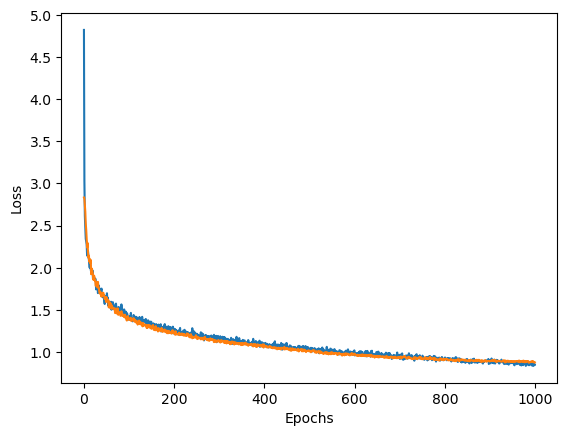

In [ ]:
#run
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("audio_dm_3_featu_.jpg")